In [1]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

from scipy.io import wavfile


In [3]:
files = r"free-spoken-digit-dataset\recordings"
ds_files = os.listdir(files)

X = []
y = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate,data = wavfile.read(os.path.join(files,file))
    X.append(data.astype(np.float16))
    y.append(label)

In [4]:
len(X), len(y)

(3000, 3000)

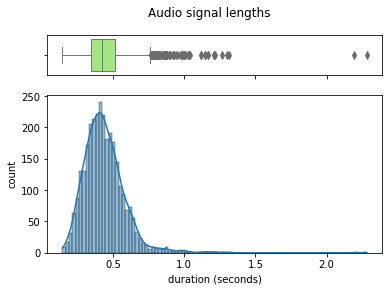

In [6]:
rate = 8000
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(X)

Text(0.5, 1.0, 'Longest audio signal')

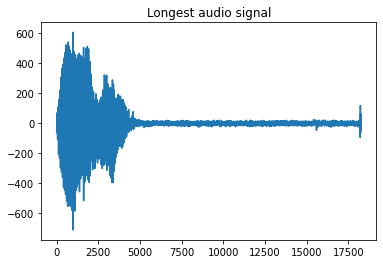

In [8]:
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio])
plt.title("Longest audio signal")

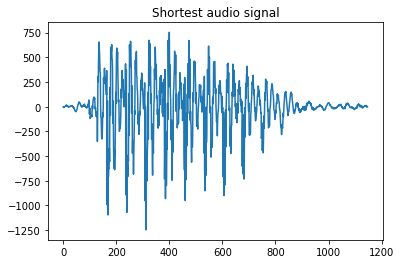

In [11]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio])
plt.title("Shortest audio signal");

ipd.Audio(X[Shortest_audio], rate=rate)

In [12]:
def remove_silence(sample, sr= 8000, top_db = 10):
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

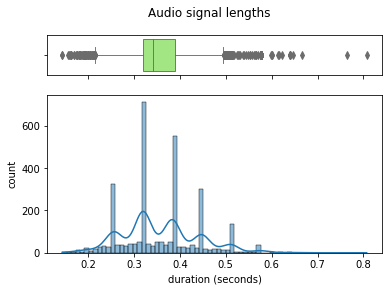

[0.298,
 0.512,
 0.448,
 0.448,
 0.50625,
 0.512,
 0.512,
 0.512,
 0.448,
 0.448,
 0.512,
 0.494125,
 0.576,
 0.448,
 0.4685,
 0.495375,
 0.448,
 0.448,
 0.448,
 0.512,
 0.448,
 0.49525,
 0.512,
 0.512,
 0.41075,
 0.27175,
 0.512,
 0.448,
 0.448,
 0.42725,
 0.384,
 0.32,
 0.3355,
 0.370625,
 0.512,
 0.448,
 0.37825,
 0.384,
 0.4125,
 0.456125,
 0.448,
 0.466625,
 0.448,
 0.448,
 0.51025,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.448,
 0.512,
 0.576,
 0.576,
 0.448,
 0.512,
 0.512,
 0.512,
 0.448,
 0.448,
 0.576,
 0.512,
 0.448,
 0.448,
 0.512,
 0.448,
 0.526,
 0.512,
 0.448,
 0.512,
 0.512,
 0.512,
 0.448,
 0.448,
 0.448,
 0.448,
 0.576,
 0.576,
 0.576,
 0.576,
 0.576,
 0.576,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.448,
 0.512,
 0.512,
 0.512,
 0.512,
 0.512,
 0.448,
 0.576,
 0.443375,
 0.492375,
 0.384,
 0.448,
 0.448,
 0.384,
 0.384,
 0.435375,
 0.384,
 0.448,
 0.484,
 0.499625,
 0.448,
 0.448,
 0.43575,
 0.448,
 0.401625,
 0.448,
 0.448,


In [13]:
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr)

In [14]:
N = int(rate * 0.8) # 0.8 is the upper limit of trimmed audio length
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

In [15]:
def into_bins(X, bins = 20):
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        As = np.array_split(np.array(x), 20)
        for a in As:
            mean = np.round(a.mean(dtype=np.float64), 4)
            sd = np.round(a.std(dtype=np.float64), 4)
            x_mean_sd.extend([mean, sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

In [16]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [18]:
rs=99
for bins in range(20,101,20):
    X_mean_sd = into_bins(X_uniform, bins)
    X_train, X_test, y_train, y_test = train_test_split(X_mean_sd, y, test_size = 0.20, random_state = rs)
    clf = RFC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    print(f"for {bins} bins, f-macro average:{f.mean()}, accuracy: {acc}")

for 20 bins, f-macro average:0.5610668986167424, accuracy: 0.565
for 40 bins, f-macro average:0.5600703251076796, accuracy: 0.5666666666666667
for 60 bins, f-macro average:0.5662802116502272, accuracy: 0.5716666666666667
for 80 bins, f-macro average:0.5709359135643861, accuracy: 0.5766666666666667
for 100 bins, f-macro average:0.5801724878312448, accuracy: 0.585


In [19]:
X_time = into_bins(X_uniform, 60)
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size = 0.20, random_state = rs)

In [20]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = rs, n_jobs = -1 )
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
grid_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", grid_search.best_params_)
print("best score:", grid_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 200}
best score: 0.5827020855078112


 Results on test dataset:


              precision    recall  f1-score   support

           0       0.61      0.77      0.68        62
           1       0.57      0.50      0.53        58
           2       0.45      0.46      0.46        56
           3       0.35      0.23      0.27        62
           4       0.43      0.49      0.46        63
           5       0.54      0.42      0.47        62
           6       0.81      0.86      0.83        56
           7       0.76      0.67      0.72        58
           8       0.70      0.77      0.73        62
           9       0.52      0.62      0.57        61

    accuracy                           0.58       600
   macro avg       0.57      0.58      0.57       600
weighted avg       0.57      0.58      0.57       600

